# Анализ ассоциативных правил на датасете покупок в магазине


**Цель работы:** Исследование ассоциативных правил между товарами в транзакциях магазина с использованием алгоритмов FPGrowth и Apriori.

**Задачи:**
- Провести предварительный анализ данных
- Применить алгоритмы поиска ассоциативных правил
- Визуализировать полученные результаты
- Проанализировать найденные закономерности

## Анализ данных

### Загрузка и первичный анализ данных

Исходные данные были загружены из файла groceries.csv. Для корректной обработки пришлось использовать ручной парсинг, так как стандартная загрузка через pd.read_csv не сработала. В результате был создан DataFrame размером 9835 строк на 32 колонки, где каждая строка - это отдельная транзакция, а колонки - товар в этой транзакции.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

try:
    all_data = pd.read_csv('groceries.csv', header=None)
    print("Данные загружены через pandas")
except:
    with open('groceries.csv', 'r') as f:
        lines = f.readlines()
    
    transactions = []
    for line in lines:
        items = [item.strip() for item in line.strip().split(',') if item.strip()]
        if items:
            transactions.append(items)

    max_len = max(len(transaction) for transaction in transactions)
    data_dict = {}
    for i in range(max_len):
        data_dict[i] = [transaction[i] if i < len(transaction) else None for transaction in transactions]
    
    all_data = pd.DataFrame(data_dict)
    print("Данные загружены через ручную обработку")

print("Размер датасета:", all_data.shape)

Данные загружены через ручную обработку
Размер датасета: (9835, 32)


### Анализ транзакций

Статистика по длине транзакций:
Минимальная длина: 1
Максимальная длина: 32
Средняя длина: 4.41


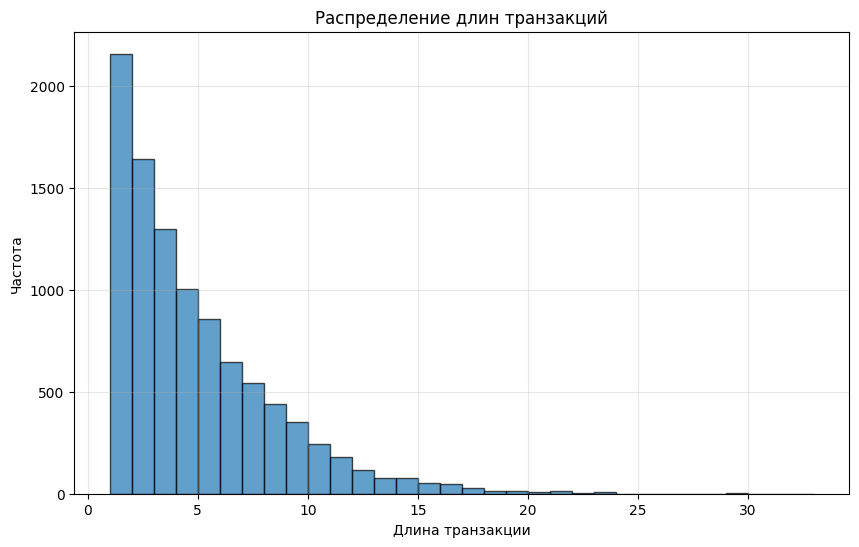

In [14]:
transaction_lengths = all_data.notnull().sum(axis=1)
print("Статистика по длине транзакций:")
print(f"Минимальная длина: {transaction_lengths.min()}")
print(f"Максимальная длина: {transaction_lengths.max()}")
print(f"Средняя длина: {transaction_lengths.mean():.2f}")

plt.figure(figsize=(10, 6))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2), 
         edgecolor='black', alpha=0.7)
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.grid(True, alpha=0.3)
plt.show()

Гистограмма распределения размерностей транзакций показывает правую асимметрию - большинство покупок содержат от 1 до 10 товаров, с резким спадом частоты для более крупных транзакций.

### Уникальные товары

In [15]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)

print(f"Количество уникальных товаров: {len(unique_items)}")

Количество уникальных товаров: 168


## Ход работы

### Предобработка данных

In [16]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)
print("Бинаризированные данные:")
print(data.head())
print(f"\nРазмер бинарной матрицы: {data.shape}")

Бинаризированные данные:
   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics  baby food   bags  baking powder  bathroom cleaner   beef  \
0           False      False  False          False             False  False   
1           False      False  False          False             False  False   
2           False      False  False          False             False  False   
3           False      False  False          False             False  False   
4           False      False  False          False             False  False   

   ...  turkey  vinegar  waffles  whipped/sour cream  w

Транзакции были преобразованы в бинарную матрицу размером 9835×168. Каждая ячейка этой матрицы показывает наличие или отсутствие конкретного товара в транзакции.

### Применение алгоритма FPGrowth

In [17]:
min_support = 0.03
df1 = fpgrowth(data, min_support=min_support, use_colnames=True)
print(f"Найдено {len(df1)} частых наборов с минимальной поддержкой {min_support}")

rules_fp = association_rules(df1, metric="confidence", min_threshold=0.4)
print(f"Сгенерировано {len(rules_fp)} правил")
print("\nПервые 10 правил:")
print(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Найдено 42 частых наборов с минимальной поддержкой 0.03
Сгенерировано 4 правил

Первые 10 правил:
          antecedents         consequents   support  confidence      lift
0            (yogurt)        (whole milk)  0.047077    0.403662  2.210475
1  (other vegetables)        (whole milk)  0.060702    0.413721  2.265562
2   (root vegetables)  (other vegetables)  0.037011    0.464286  3.164414
3   (root vegetables)        (whole milk)  0.038129    0.478316  2.619288


Алгоритм FPGrowth был применен с минимальной поддержкой 0.03, рассматриваются только наборы товаров, встречающиеся как минимум в 3% всех транзакций.

Минимальная поддержка - доля транзакций, в которых встречается набор товаров.
Минимальная достоверность правила - вероятность того, что если купили товары из левой части правила, то купят и из правой.

Полезные правила показывают действительно сильные связи между товарами.

Тривиальные правила — часто имеют высокую поддержку, но низкий лифт, то есть не дают новой информации.

Лифт показывает, насколько вероятность покупки товара из правой части правила выше, чем если бы товары покупались независимо. Лифт > 1 говорит о наличии положительной связи


Полезные правила:

Правило 2: <b>"root vegetables → other vegetables"</b>
Лифт: 3.164 - Покупатели корнеплодов в 3.16 раза чаще покупают другие овощи.
Достоверность: 0.464 - Покупают вместе c корнеплодами также берут другие овощи в 46.4% случаях.
Поддержка: 0.037 - Встречается в 3.7% транзакций.

Правило 3: <b>"root vegetables → whole milk"</b>
Лифт: 2.619 - Покупатели корнеплодов в 2.62 раза чаще покупают молоко.
Достоверность: 0.478 - Почти половина покупателей корнеплодов также берут молоко.
Поддержка: 0.038 - Встречается в 3.8% транзакций.

Правило 1: <b>"other vegetables → whole milk"</b>
Лифт: 2.266 - Покупатели других овощей в 2.27 раза чаще покупают молоко.
Достоверность: 0.414 - 41.4% покупателей овощей также берут молоко.
Поддержка: 0.061 - Встречается в 6.1% транзакций.

Правило 0: <b>"yogurt → whole milk"</b>
Лифт: 2.210 - Покупатели йогурта в 2.21 раза чаще покупают молоко.
Достоверность: 0.404 - 40.4% покупателей йогурта также берут молоко.
Поддержка: 0.047 - Встречается в 4,7% транзакций.

Тривиальных правил нет.

### Применение алгоритма Apriori

In [18]:
df2 = apriori(data, min_support=min_support, use_colnames=True)
print(f"Apriori: найдено {len(df2)} частых наборов")

rules_ap = association_rules(df2, metric="confidence", min_threshold=0.4)
print(f"Apriori: сгенерировано {len(rules_ap)} правил")

print("\nПравила Apriori:")
print(rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

print("\nСравнение алгоритмов:")
print(f"FPGrowth: {len(df1)} наборов, {len(rules_fp)} правил")
print(f"Apriori: {len(df2)} наборов, {len(rules_ap)} правил")

Apriori: найдено 42 частых наборов
Apriori: сгенерировано 4 правил

Правила Apriori:
          antecedents         consequents   support  confidence      lift
0   (root vegetables)  (other vegetables)  0.037011    0.464286  3.164414
1  (other vegetables)        (whole milk)  0.060702    0.413721  2.265562
2   (root vegetables)        (whole milk)  0.038129    0.478316  2.619288
3            (yogurt)        (whole milk)  0.047077    0.403662  2.210475

Сравнение алгоритмов:
FPGrowth: 42 наборов, 4 правил
Apriori: 42 наборов, 4 правил


Полезные правила:

Правило 0: <b>"root vegetables → other vegetables"</b>
Лифт: 3.164 - Покупатели корнеплодов в 3.16 раза чаще покупают другие овощи.
Достоверность: 0.464 - Покупают вместе c корнеплодами также берут другие овощи в 46.4% случаях.
Поддержка: 0.037 - Встречается в 3.7% транзакций.

Правило 2: <b>"root vegetables → whole milk"</b>
Лифт: 2.619 - Покупатели корнеплодов в 2.62 раза чаще покупают молоко.
Достоверность: 0.478 - Почти половина покупателей корнеплодов также берут молоко.
Поддержка: 0.038 - Встречается в 3.8% транзакций.

Правило 1: <b>"other vegetables → whole milk"</b>
Лифт: 2.266 - Покупатели других овощей в 2.27 раза чаще покупают молоко.
Достоверность: 0.414 - 41.4% покупателей овощей также берут молоко.
Поддержка: 0.061 - Встречается в 6.1% транзакций.

Правило 3: <b>"yogurt → whole milk"</b>
Лифт: 2.210 - Покупатели йогурта в 2.21 раза чаще покупают молоко.
Достоверность: 0.404 - 40.4% покупателей йогурта также берут молоко.
Поддержка: 0.047 - Встречается в 4,7% транзакций.

Тривиальных правил нет.


Оба алгоритма показали одинаковые результаты по количеству найденных наборов и правил, что подтверждает корректность реализации и согласованность методов.

### Анализ поддержки товаров

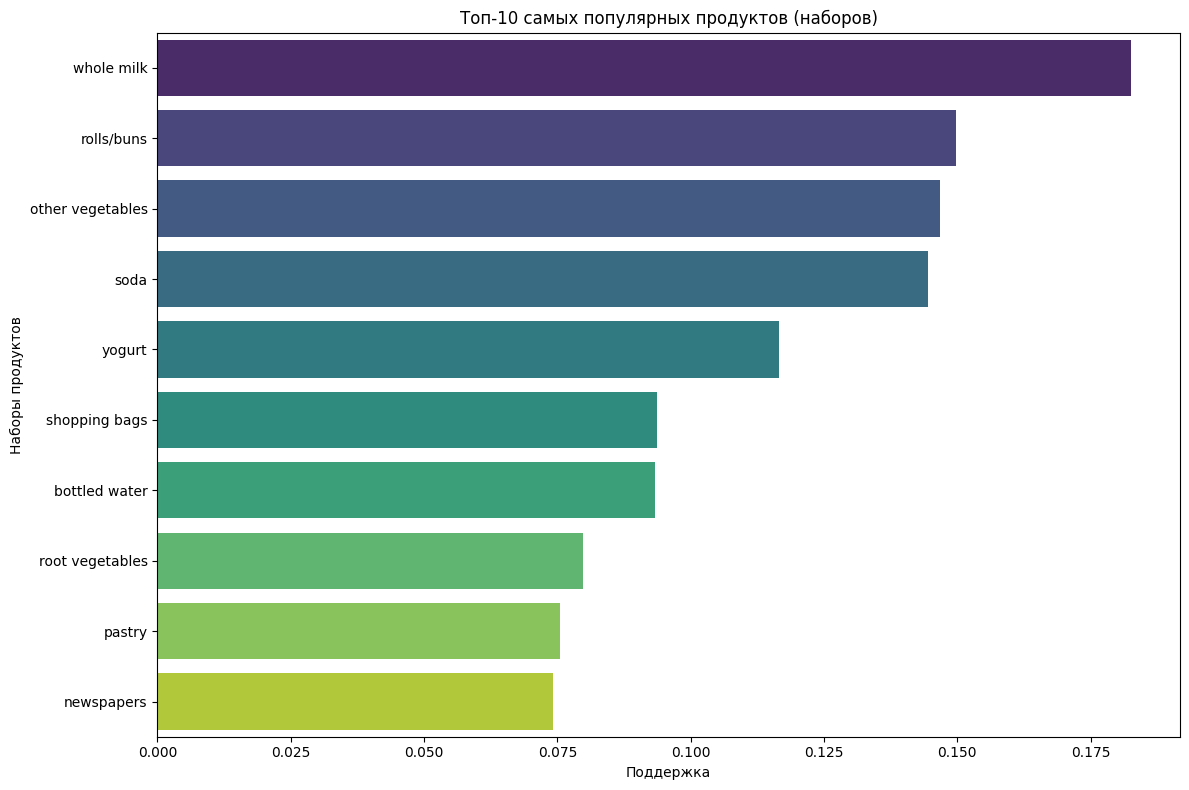

Топ-10 продуктов по поддержке:
           itemsets   support
0        whole milk  0.182613
1        rolls/buns  0.149771
2  other vegetables  0.146721
3              soda  0.144484
4            yogurt  0.116624
5     shopping bags  0.093645
6     bottled water  0.093238
7   root vegetables  0.079715
8            pastry  0.075547
9        newspapers  0.074123


In [19]:
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemsets', data=top_products, 
            hue='itemsets', palette='viridis', legend=False)
plt.title('Топ-10 самых популярных продуктов (наборов)')
plt.xlabel('Поддержка')
plt.ylabel('Наборы продуктов')
plt.tight_layout()
plt.show()

print("Топ-10 продуктов по поддержке:")
print(top_products[['itemsets', 'support']])

Цельное молоко демонстрирует наивысшую поддержку (18.26%), булочки и другие овощи также показывают высокую популярность с поддержкой около 15%.

### Анализ ассоциативных правил

In [20]:
rules = rules_fp.copy()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

print("Статистика по метрикам правил:")
print(f"Достоверность (confidence): min={rules['confidence'].min():.3f}, max={rules['confidence'].max():.3f}")
print(f"Поддержка (support): min={rules['support'].min():.3f}, max={rules['support'].max():.3f}")
print(f"Лифт (lift): min={rules['lift'].min():.3f}, max={rules['lift'].max():.3f}")

best_rules = rules.nlargest(5, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("\nТоп-5 правил по лифту:")
print(best_rules)

Статистика по метрикам правил:
Достоверность (confidence): min=0.404, max=0.478
Поддержка (support): min=0.037, max=0.061
Лифт (lift): min=2.210, max=3.164

Топ-5 правил по лифту:
        antecedents       consequents   support  confidence      lift
2   root vegetables  other vegetables  0.037011    0.464286  3.164414
3   root vegetables        whole milk  0.038129    0.478316  2.619288
1  other vegetables        whole milk  0.060702    0.413721  2.265562
0            yogurt        whole milk  0.047077    0.403662  2.210475


### Визуализация достоверности правил

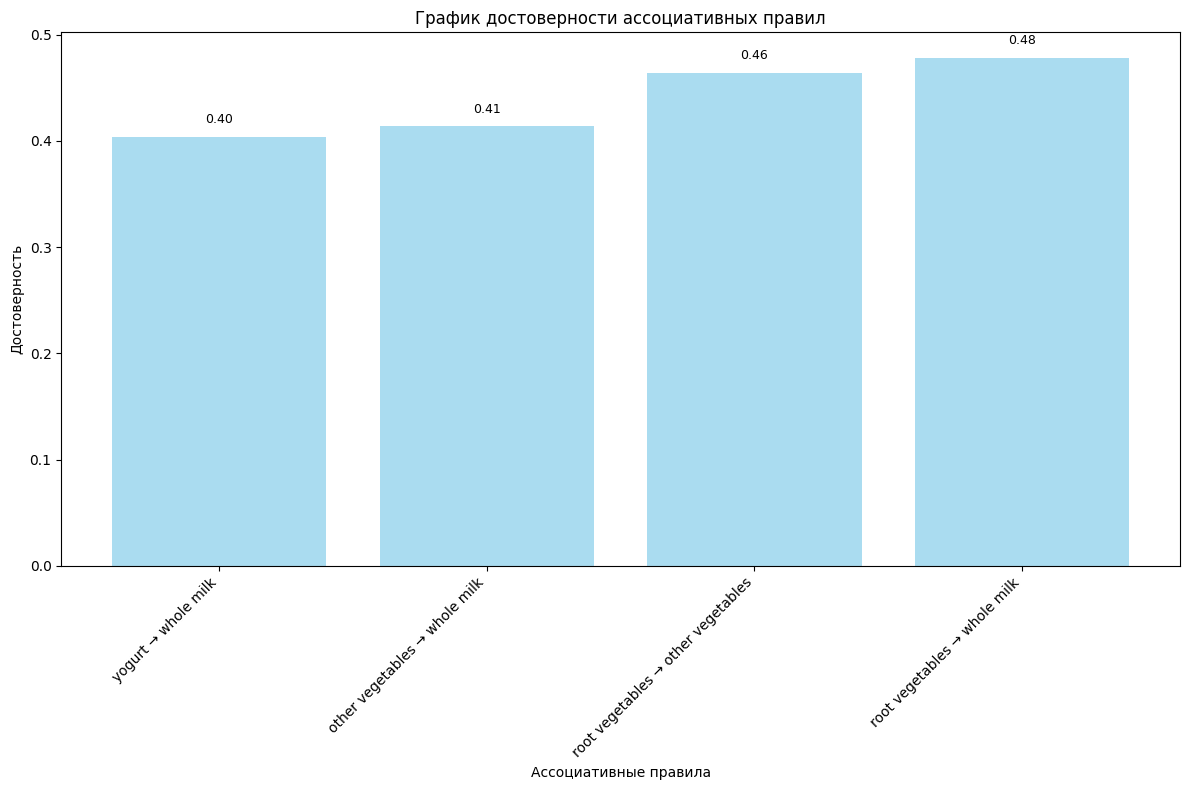

In [21]:
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()

rules_labels = [f"{p1} → {p2}" for p1, p2 in zip(products_1, products_2)]

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(rules_labels)), confidence, color='skyblue', alpha=0.7)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности ассоциативных правил")

for bar, conf in zip(bars, confidence):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{conf:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(range(len(rules_labels)), rules_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Правила с более высокой поддержкой имеют несколько меньшую достоверность.

### Сетевая визуализация ассоциативных правил

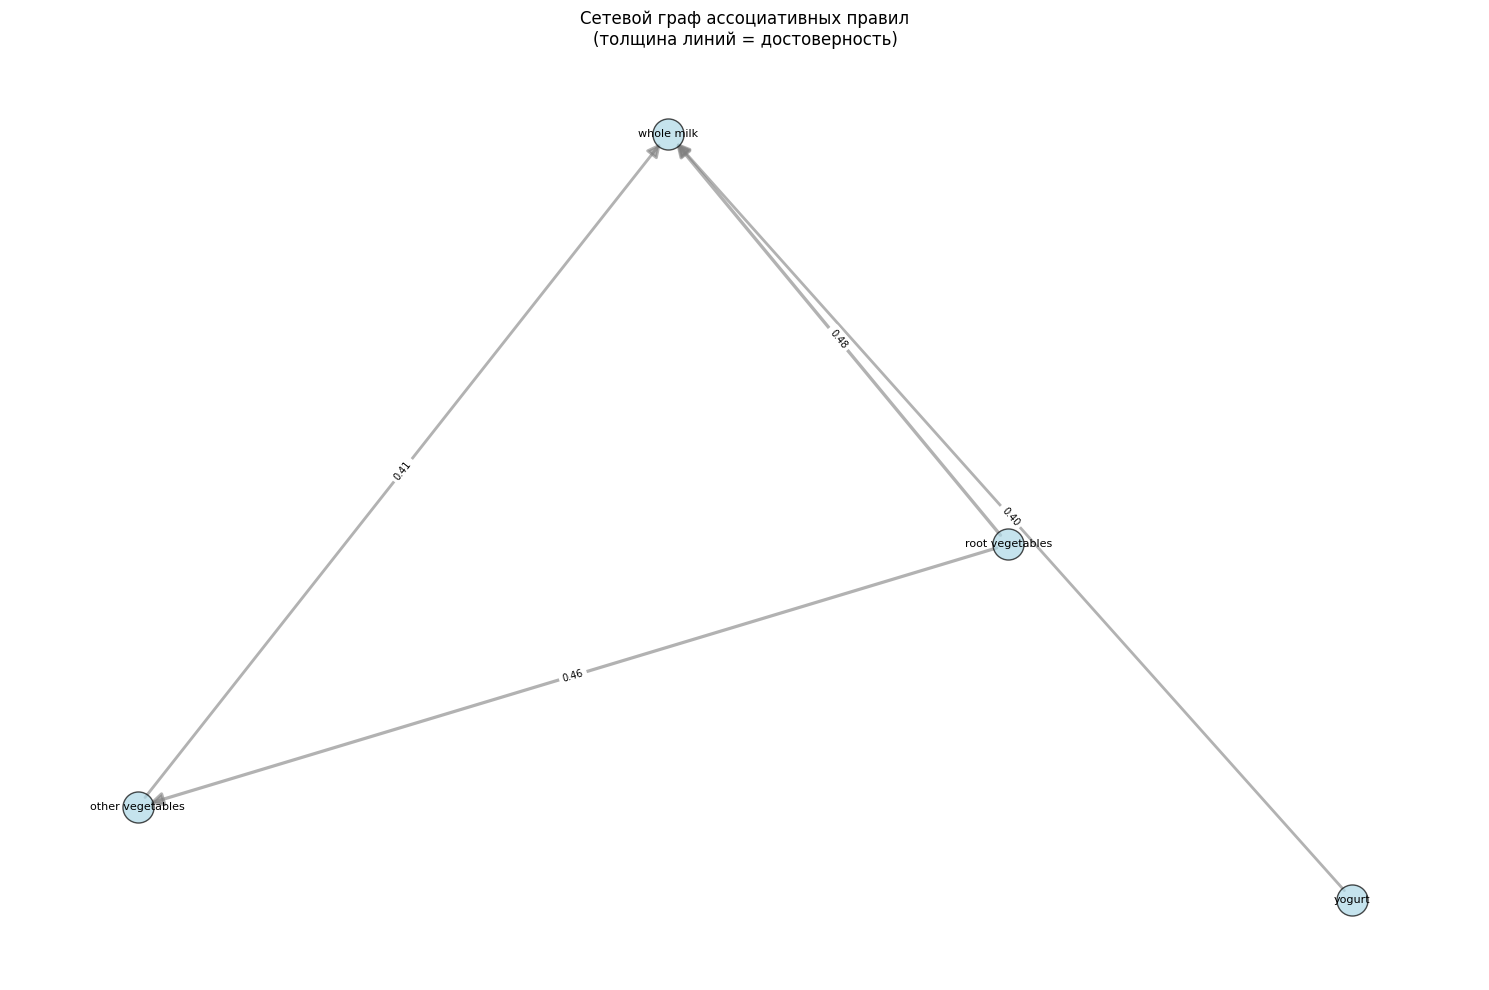

Граф содержит 4 узлов и 4 ребер
Плотность графа: 0.333


In [22]:
G = nx.DiGraph()

for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], 
               weight=row['confidence'],
               support=row['support'],
               lift=row['lift'])

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1, iterations=50)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', 
                       alpha=0.7, edgecolors='black')

edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6, 
                      edge_color='gray', arrows=True, arrowsize=20)

nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title('Сетевой граф ассоциативных правил\n(толщина линий = достоверность)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Граф содержит {G.number_of_nodes()} узлов и {G.number_of_edges()} ребер")
print(f"Плотность графа: {nx.density(G):.3f}")

Вершины графа — это товары, а стрелки — ассоциативные правила между ними. 

Значения достоверности: 0.40, 0.41, 0.46, 0.48. 

### Эксперименты с параметрами

Влияние минимальной поддержки:
   min_support  frequent_itemsets  rules
0         0.02                 81     12
1         0.03                 42      4
2         0.05                 19      1
3         0.10                  5      0


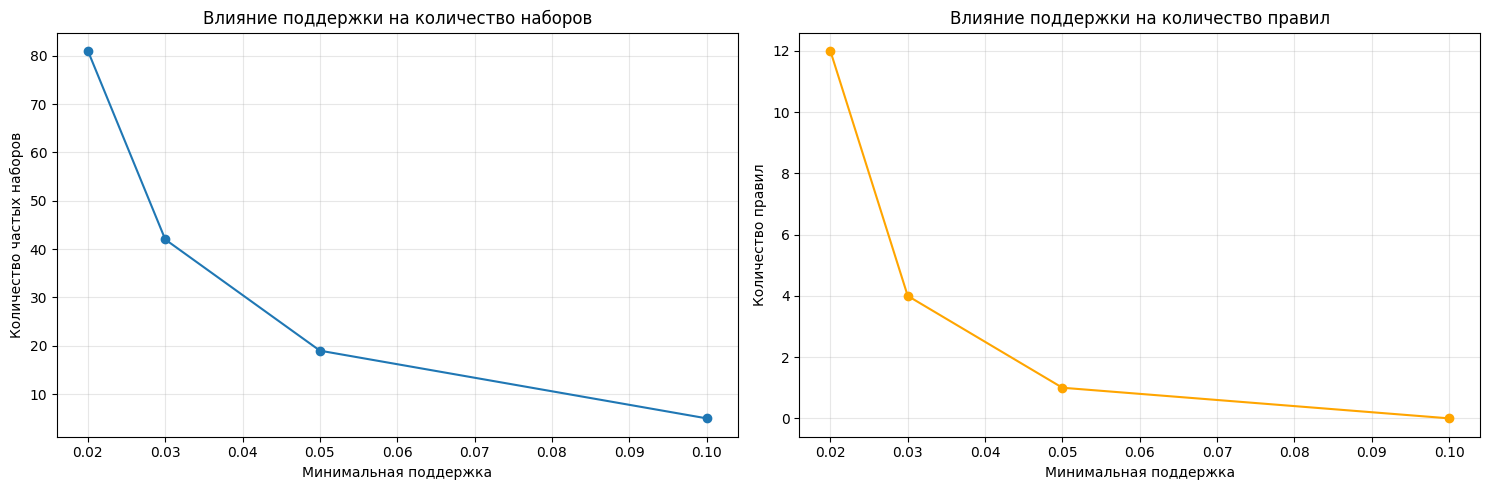

In [23]:
support_values = [0.02, 0.03, 0.05, 0.1]
results = []

for sup in support_values:
    df_temp = fpgrowth(data, min_support=sup, use_colnames=True)
    rules_temp = association_rules(df_temp, metric="confidence", min_threshold=0.4)
    results.append({
        'min_support': sup,
        'frequent_itemsets': len(df_temp),
        'rules': len(rules_temp)
    })

results_df = pd.DataFrame(results)
print("Влияние минимальной поддержки:")
print(results_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(results_df['min_support'], results_df['frequent_itemsets'], marker='o')
ax1.set_xlabel('Минимальная поддержка')
ax1.set_ylabel('Количество частых наборов')
ax1.set_title('Влияние поддержки на количество наборов')
ax1.grid(True, alpha=0.3)

ax2.plot(results_df['min_support'], results_df['rules'], marker='o', color='orange')
ax2.set_xlabel('Минимальная поддержка')
ax2.set_ylabel('Количество правил')
ax2.set_title('Влияние поддержки на количество правил')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

На основе проведенного эксперимента с разными значениями минимальной поддержки (min_support) можно сделать следующие выводы:

- Количество частых наборов резко уменьшается с ростом порога поддержки

- Количество ассоциативных правил также снижается с ростом min_support

- Низкий порог поддержки позволяет выявить больше правил, включая редкие связи. Однако среди них может быть много шумовых или менее значимых правил. Высокий порог поддержки отсекает редкие наборы, оставляя только самые устойчивые и часто встречающиеся, но при этом количество правил может стать слишком малым для практического использования.

### Визуализация метрик ассоциативных правил с помощью круговой диаграммы

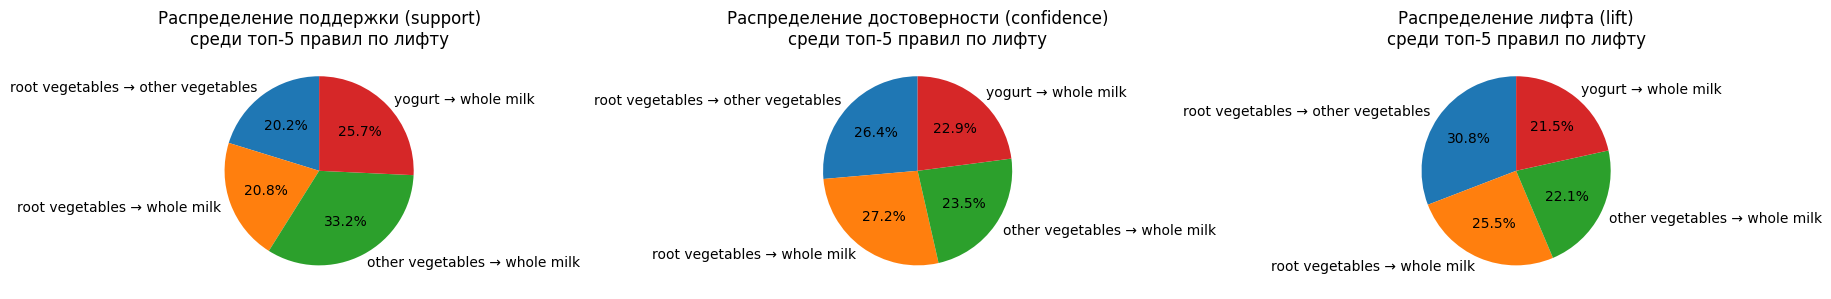


Анализ состава правил:


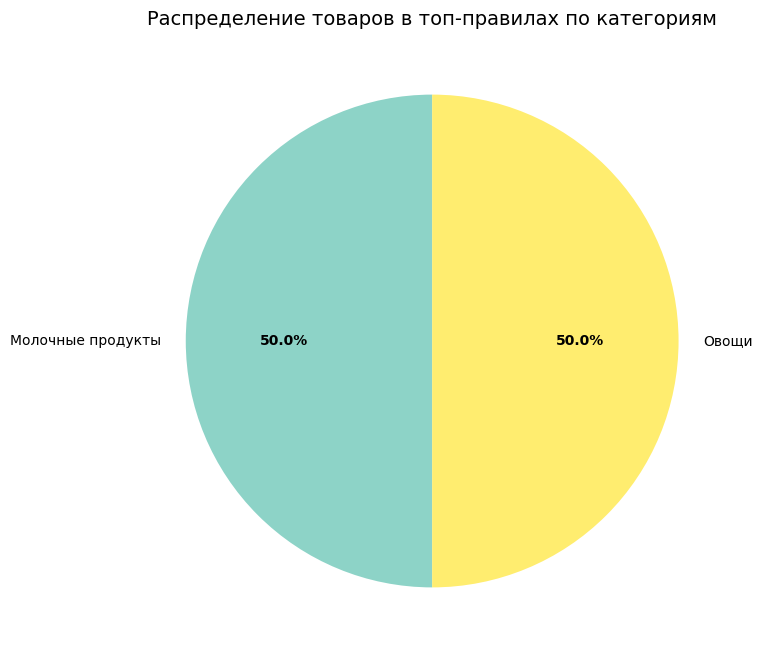


Статистика по категориям товаров в топ-правилах:
Молочные продукты: 2 товар(ов)
Овощи: 2 товар(ов)


In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

top_rules = rules.nlargest(5, 'lift')

support_values = top_rules['support'] * 100
labels_support = [f"{ant} → {cons}" for ant, cons in 
                 zip(top_rules['antecedents'], top_rules['consequents'])]

ax1.pie(support_values, labels=labels_support, autopct='%1.1f%%', startangle=90)
ax1.set_title('Распределение поддержки (support)\nсреди топ-5 правил по лифту', fontsize=12)

confidence_values = top_rules['confidence'] * 100
ax2.pie(confidence_values, labels=labels_support, autopct='%1.1f%%', startangle=90)
ax2.set_title('Распределение достоверности (confidence)\nсреди топ-5 правил по лифту', fontsize=12)

lift_values = top_rules['lift']
ax3.pie(lift_values, labels=labels_support, autopct='%1.1f%%', startangle=90)
ax3.set_title('Распределение лифта (lift)\nсреди топ-5 правил по лифту', fontsize=12)

plt.tight_layout()
plt.show()

print("\nАнализ состава правил:")

all_items_in_rules = set()
for _, rule in top_rules.iterrows():
    all_items_in_rules.update(rule['antecedents'].split(', '))
    all_items_in_rules.update(rule['consequents'].split(', '))

categories = {
    'Молочные продукты': ['whole milk', 'yogurt'],
    'Овощи': ['other vegetables', 'root vegetables'],
    'Фрукты': ['tropical fruit', 'citrus fruit'],
    'Мясо': ['beef', 'pork', 'chicken'],
    'Напитки': ['soda', 'bottled water', 'bottled beer'],
    'Хлебобулочные': ['rolls/buns', 'pastry']
}

category_count = {category: 0 for category in categories}
uncategorized = 0

for item in all_items_in_rules:
    categorized = False
    for category, items in categories.items():
        if item in items:
            category_count[category] += 1
            categorized = True
            break
    if not categorized:
        uncategorized += 1

fig, ax = plt.subplots(figsize=(10, 8))

categories_for_chart = {k: v for k, v in category_count.items() if v > 0}
if uncategorized > 0:
    categories_for_chart['Другие'] = uncategorized

colors = plt.cm.Set3(np.linspace(0, 1, len(categories_for_chart)))
wedges, texts, autotexts = ax.pie(categories_for_chart.values(), 
                                  labels=categories_for_chart.keys(),
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  startangle=90)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

ax.set_title('Распределение товаров в топ-правилах по категориям', fontsize=14)
plt.show()

print("\nСтатистика по категориям товаров в топ-правилах:")
for category, count in categories_for_chart.items():
    print(f"{category}: {count} товар(ов)")

## Заключение

   - Оба алгоритма нашли идентичные наборы при одинаковых параметрах.

   - Выявлены устойчивые ассоциации между определенными группами товаров.

   - Правила с высокой достоверностью часто имеют умеренные значения лифта.


## Листинг кода

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

all_data = pd.read_csv('market.csv')
print("Анализ датасета:")
print(f"Размер: {all_data.shape}")
print(f"Количество транзакций: {len(all_data)}")

transaction_lengths = all_data.notnull().sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2), 
         edgecolor='black', alpha=0.7)
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

min_support = 0.03
df1 = fpgrowth(data, min_support=min_support, use_colnames=True)
rules = association_rules(df1, metric="confidence", min_threshold=0.4)

df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemsets', data=top_products, palette='viridis')
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

G = nx.DiGraph()
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightgreen', 
        font_size=8, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()

print("Анализ завершен успешно!")
```